In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.image import resize_with_pad
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dropout, LeakyReLU, MaxPooling2D, UpSampling2D

In [6]:
BASE_IMAGE_PATH = 'drive/My Drive/dataset/Images'
BASE_LABELS_PATH = 'drive/My Drive/dataset/Labels'
TARGET_IMAGE_SIZE = (256, 256)
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 200
VAL_SPLIT = 0.2

In [4]:
from tqdm import tqdm

In [7]:
image_data = []
image_labels = []

image_count = len(os.listdir(BASE_IMAGE_PATH))

for i in tqdm(range(1, image_count + 1)):
    img = load_img(os.path.join(BASE_IMAGE_PATH, str(i) + '.jpeg'))
    img = img_to_array(img, dtype = 'uint8')
    image_data.append(img)
    
    label_mask = np.zeros((*img.shape[:2], 1))
    
    with open(os.path.join(BASE_LABELS_PATH, str(i) + '.txt'), 'r') as label_file:
        l_count = int(label_file.readline())
        
        for i in range(l_count):
            box = list(map(int, label_file.readline().split()))
            label_mask[box[1]:box[3], box[0]:box[2]] = 1.0
        
    image_labels.append(label_mask)

100%|██████████| 333/333 [01:11<00:00,  4.68it/s]


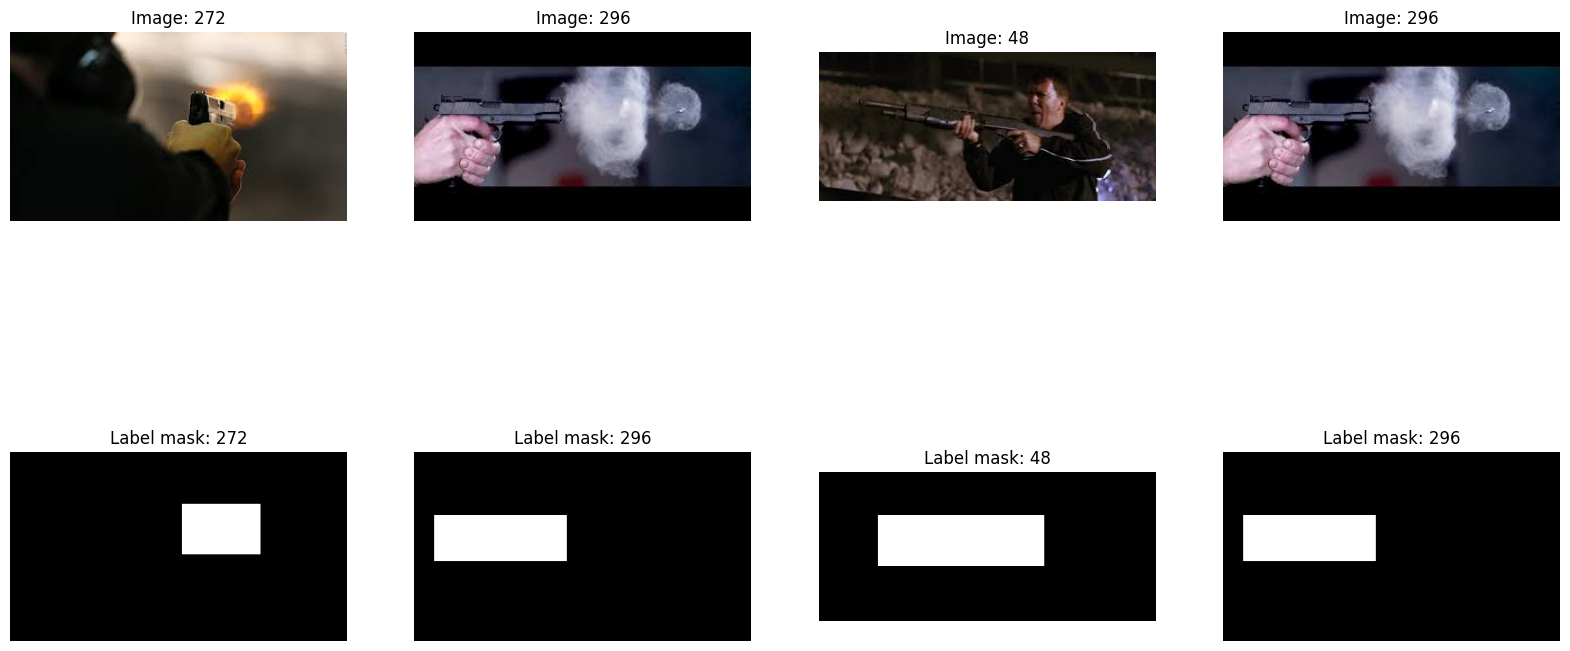

In [8]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in enumerate(np.random.randint(0, image_count, size = 4)):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [9]:
for i in tqdm(range(image_count)):
    image_data[i] = resize_with_pad(image_data[i], *TARGET_IMAGE_SIZE).numpy() / 255.0
    image_labels[i] = resize_with_pad(image_labels[i], *TARGET_IMAGE_SIZE).numpy()

100%|██████████| 333/333 [00:10<00:00, 31.96it/s]


4it [00:00, 282.68it/s]


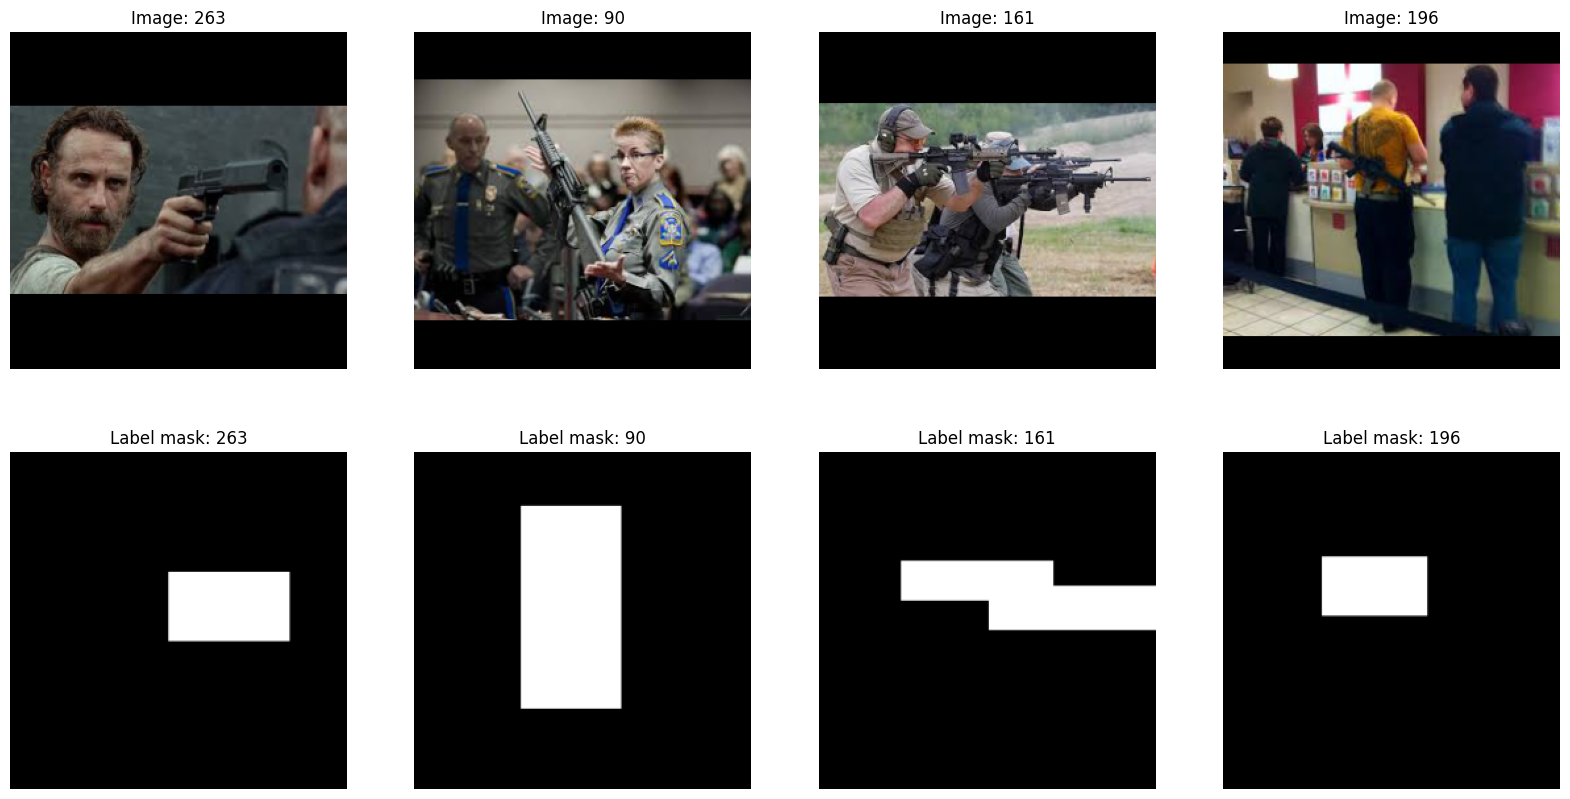

In [10]:
plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, img_index in tqdm(enumerate(np.random.randint(0, image_count, size = 4))):
    plt.subplot(2, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(2, 4, i + 5)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Label mask: {img_index}')
    plt.imshow(image_labels[img_index], cmap = 'gray')
plt.show()

In [11]:
image_data = np.array(image_data)
image_labels = np.array(image_labels)

In [12]:
def weighted_bce(y_true, y_pred):
    LOSS_WEIGHT = 8
    loss_ones = LOSS_WEIGHT * y_true * tf.math.log(y_pred + 1e-7)
    loss_zeros = (1 - y_true) * tf.math.log(1 - y_pred + 1e-7)
    loss = - loss_ones - loss_zeros
    return tf.reduce_mean(loss)

In [13]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*TARGET_IMAGE_SIZE, 3), activation = LeakyReLU()),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),
    MaxPooling2D(),
    
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU()),
    Dropout(0.1),
    
    UpSampling2D(),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU()),

    UpSampling2D(),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU()),

    Dropout(0.1),
    Conv2D(1, 3, padding = 'same', activation = 'sigmoid'),
])

model.compile(optimizer = Adam(LEARNING_RATE), loss = weighted_bce , metrics=['accuracy', 'mse' , 'AUC'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 64, 64, 128)       0

In [14]:
%%time

history = model.fit(image_data, image_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VAL_SPLIT, verbose = 1)

Epoch 1/200
17/17 [==============================] - 22s 446ms/step - loss: 1.1044 - accuracy: 0.4041 - mse: 0.2685 - auc: 0.7323 - val_loss: 1.0678 - val_accuracy: 0.4449 - val_mse: 0.2846 - val_auc: 0.7675
Epoch 2/200
17/17 [==============================] - 4s 239ms/step - loss: 1.0833 - accuracy: 0.5332 - mse: 0.2713 - auc: 0.7163 - val_loss: 1.0251 - val_accuracy: 0.7793 - val_mse: 0.2239 - val_auc: 0.7924
Epoch 3/200
17/17 [==============================] - 4s 233ms/step - loss: 1.0019 - accuracy: 0.5668 - mse: 0.2415 - auc: 0.7814 - val_loss: 0.8751 - val_accuracy: 0.6672 - val_mse: 0.1821 - val_auc: 0.8027
Epoch 4/200
17/17 [==============================] - 4s 233ms/step - loss: 0.8602 - accuracy: 0.6651 - mse: 0.1726 - auc: 0.7935 - val_loss: 0.8275 - val_accuracy: 0.6072 - val_mse: 0.2126 - val_auc: 0.8065
Epoch 5/200
17/17 [==============================] - 4s 236ms/step - loss: 0.8266 - accuracy: 0.6772 - mse: 0.1646 - auc: 0.7952 - val_loss: 0.7731 - val_accuracy: 0.6517 

In [15]:
# Metrics of the model
history.history.keys()

dict_keys(['loss', 'accuracy', 'mse', 'auc', 'val_loss', 'val_accuracy', 'val_mse', 'val_auc'])

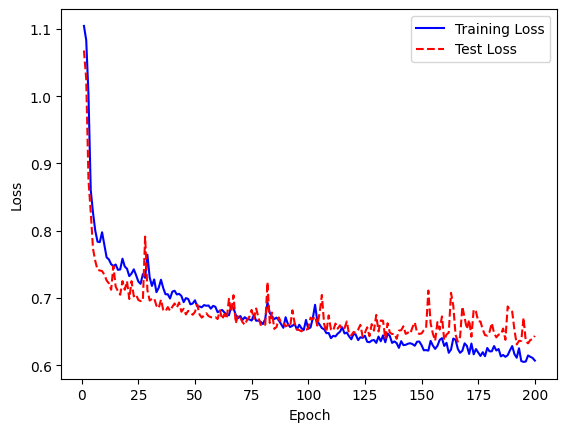

In [16]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'b-')
plt.plot(epoch_count, test_loss, 'r--')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();


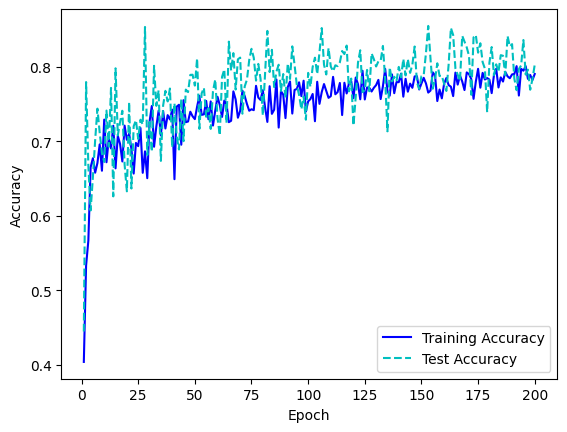

In [17]:
# Get training and test loss histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'b-')
plt.plot(epoch_count, test_accuracy, 'c--')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

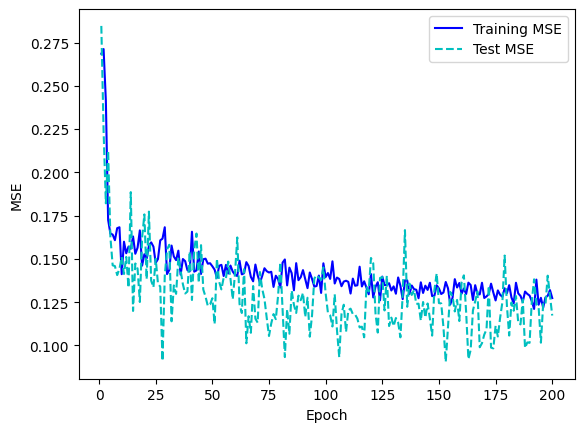

In [18]:
# Get training and test loss histories
training_accuracy = history.history['mse']
test_accuracy = history.history['val_mse']

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'b-')
plt.plot(epoch_count, test_accuracy, 'c--')
plt.legend(['Training MSE', 'Test MSE'])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show();

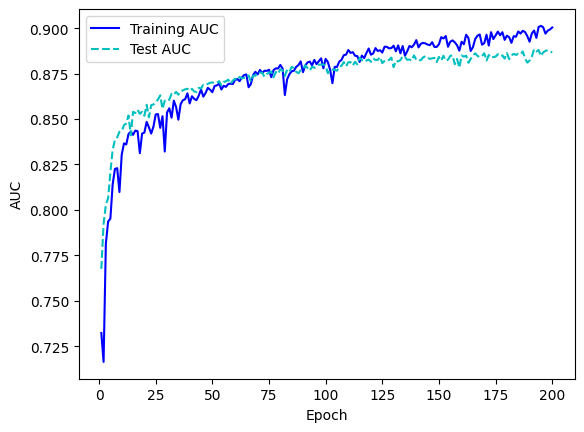

In [19]:
# Get training and test loss histories
training_accuracy = history.history['auc']
test_accuracy = history.history['val_auc']

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'b-')
plt.plot(epoch_count, test_accuracy, 'c--')
plt.legend(['Training AUC', 'Test AUC'])
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.show();

1/1 [==============================] - 0s 32ms/step


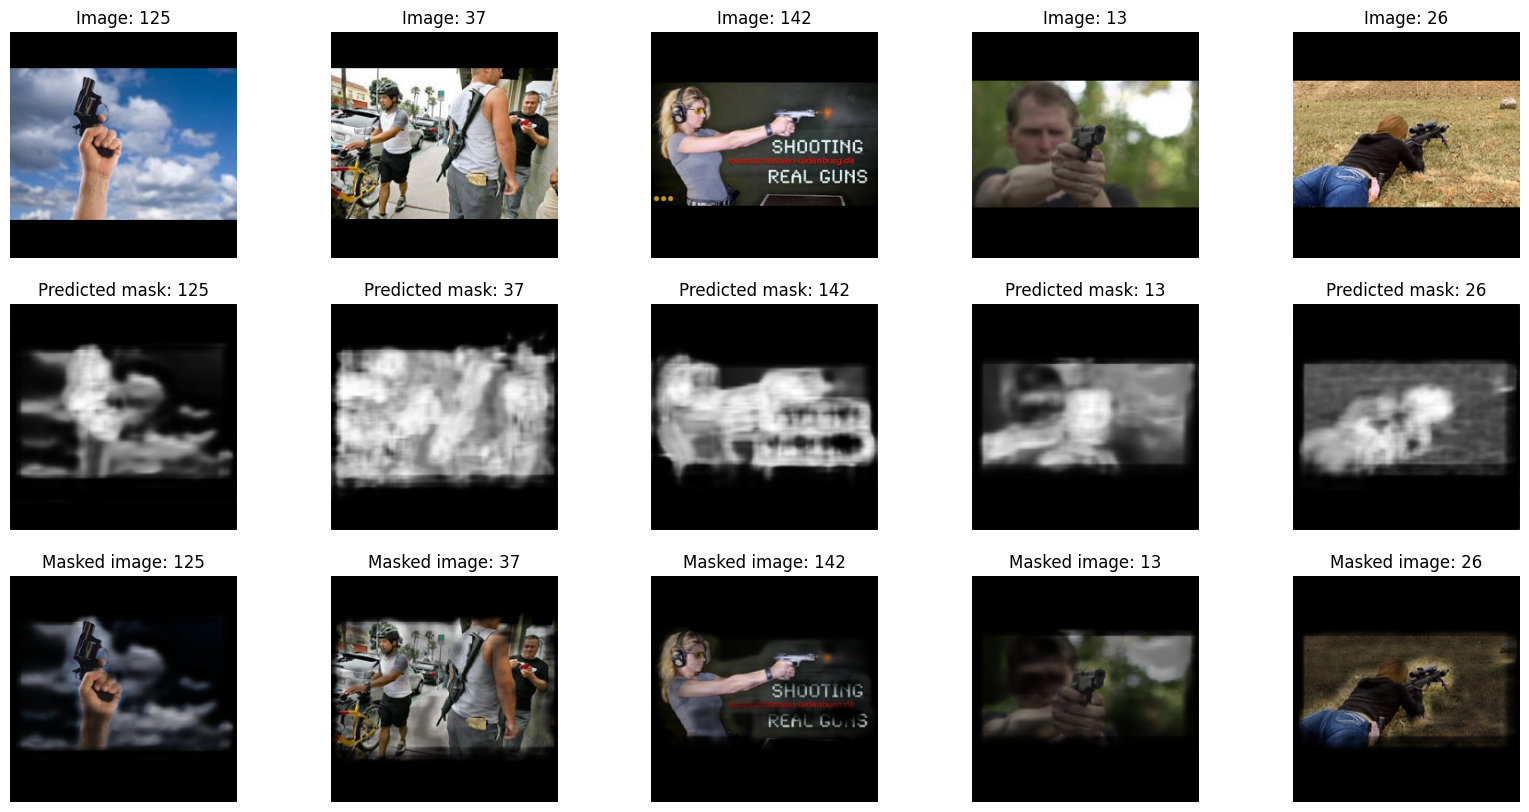

In [23]:
plt.subplots(nrows = 3, ncols = 5, figsize = (20, 10))

indices_to_predict = np.random.randint(0, image_count, size = 5)

for i, img_index in enumerate(indices_to_predict):
    preds = model.predict(image_data[indices_to_predict])
    
    masked_images = preds * image_data[indices_to_predict]
    
    plt.subplot(3, 5, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Image: {img_index}')
    plt.imshow(image_data[img_index])
    
    plt.subplot(3, 5, i + 6)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Predicted mask: {img_index}')
    plt.imshow(preds[i], cmap = 'gray')
    
    plt.subplot(3, 5, i + 11)
    plt.axis(False)
    plt.grid(False)
    plt.title(f'Masked image: {img_index}')
    plt.imshow(masked_images[i])
plt.show()